In [37]:
import pandas as pd
import plotly.express as px

# For investigating timeseries data
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Importing + Visualizing Data

In [30]:
df = pd.read_csv('./Data/quarterly_data.csv', index_col=[0])
df.head(5)

,product_line,quarter,inventory
0,XYZ,2000-03-31,1017.140259
1,XYZ,2000-06-30,1219.650466
2,XYZ,2000-09-30,1064.350634
3,XYZ,2000-12-31,821.956578
4,XYZ,2001-03-31,1008.430625


In [31]:
# Graphing data
fig = px.line(df, x = 'quarter', y = 'inventory',
              title = 'Customer Inventory Over Time')
fig.show()

### Checking if Data is Stationary

In [32]:
dftest = adfuller(df['inventory'])

# Printing results
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -0.719668
p-value: 0.841589
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586


P-value is greater than 0.05 so data is not stationary, need to difference

In [33]:
df['transformed_inventory'] = df['inventory'].diff()
# Graphing data
fig = px.line(df, x = 'quarter', y = 'transformed_inventory',
              title = 'transformed_inventory Over Time')
fig.show()

In [34]:
dftest = adfuller(df['transformed_inventory'].dropna())

# Printing results
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.291021
p-value: 0.174880
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586


### Now Fitting Moving Average (MA) model

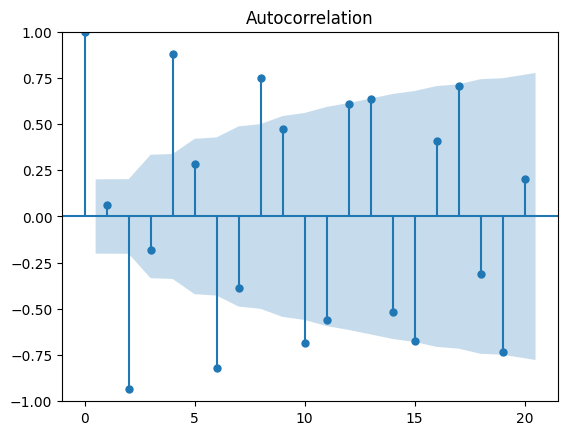

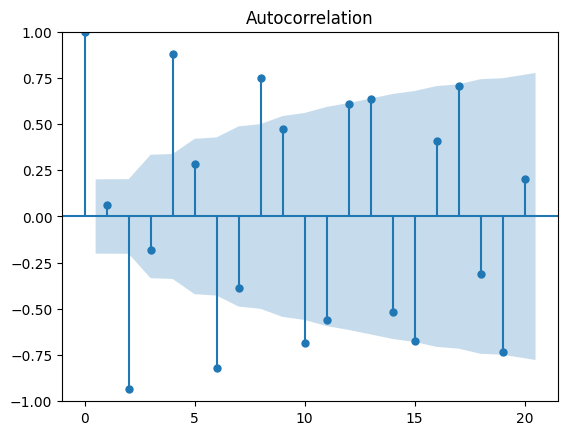

In [36]:
plot_acf(df['transformed_inventory'].dropna(), lags= 20)

### Now Training MA Model

In [ ]:
def train_MA(df, test, train_length):

    # Initializing list to store predictions
    pred_MA = []

    predictions = []
    for month in range(len(test)):
        model = SARIMAX(df[:train_length + month], order= (0, 0, 3))
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_MA.append(output)

    return pred_MA

train_len = len(train)
test_len = len(test)
window = 2